# **Global Sentiment**

Este es el notebook que usaremos para el scrapeo de datos


In [1]:
import datetime
from datetime import timedelta

import os
import re

import snscrape.modules.twitter as snstwitter

import pandas as pd
import seaborn as sns
import numpy as np

## **Parameter Settings**

In [2]:
date_init = "2017-01-02"
date_limit = "2021-05-15"

## **Read Databases**

In [3]:
t_path = "JABA/data/tweets"
t_file = "tweet_list.csv"
s_file = "tweet_sentiment_nltk.csv"

La base de datos esta formada por millones de filas y no usaremos todas las columnas, por lo que, para acelerar el proceso, eliminaremos las columnas no usadas.

En este caso, ademas, la columna Text, es la columna con mayor peso en memoria, por lo que eliminarla aligerara la carga en RAM.

In [33]:
str(datetime.datetime.strptime(date_init, '%Y-%m-%d').date())

'2017-01-02'

In [59]:
t_path

'JABA/data/tweets'

In [34]:
unused_columns = ['Text', 'Tweet Id', 'NumReplies', 'NumRetweets', 'IDOriginalRetweeted', 'isVerified'  ]

def drop_unused_columns(dataframe):
    return dataframe.drop(unused_columns,  axis=1)

def prepare_data(dataframe):
    dataframe["Datetime"] = pd.to_datetime(dataframe["Datetime"])
    dataframe['sentiment_v'] = ( 1 + np.log2(1 + dataframe['NumLikes']) ) * dataframe['sentiment'] 
    dataframe["rount_datetime"] = dataframe["Datetime"].dt.floor("30T")
    
    dataframe["date"] = dataframe["Datetime"].dt.date
    dataframe = dataframe.set_index('date')
    
    return dataframe.groupby("rount_datetime").sum()
    
def get_data():
    frames = []
    date_from = datetime.datetime.strptime(date_init, '%Y-%m-%d').date()
    date_until = datetime.datetime.strptime(date_limit, '%Y-%m-%d').date()
    
    if date_from >= date_until:
        return pd.DataFrame()
    
    i = 0
    while date_from < date_until:
        i += 1
        
        folder = "JABA/data/tweets\\" + str(date_from)
        # TODO Check if file exists
        if i%365 == 0:
            print(f"Step {i} : {folder}")

        tweet_file = os.path.join(folder, t_file)
        sentiment_file = os.path.join(folder, s_file)

        tweet_df = pd.read_csv(tweet_file, sep=";")
        tweet_df = drop_unused_columns(tweet_df)

        sent_df = pd.read_csv(sentiment_file, sep=";")

        tweet_df = prepare_data(tweet_df.join(sent_df))
        
        frames += [tweet_df]
        
        date_from = date_from + timedelta(days=1)

    return pd.concat(frames, ignore_index=False)
    

In [35]:
df = get_data()

Step 365 : JABA/data/tweets\2018-01-01
Step 730 : JABA/data/tweets\2019-01-01
Step 1095 : JABA/data/tweets\2020-01-01
Step 1460 : JABA/data/tweets\2020-12-31


In [36]:
df.tail()

,NumLikes,sentiment,sentiment_v
rount_datetime,,,
2021-05-14 21:30:00+00:00,42034,397.6480,921.485883
2021-05-14 22:00:00+00:00,25447,349.6222,731.962103
2021-05-14 22:30:00+00:00,16902,356.1691,745.702575
2021-05-14 23:00:00+00:00,30952,334.9281,773.327462
2021-05-14 23:30:00+00:00,15831,291.8743,651.716570


## **Sentimiento Global**

A la hora de trabajar con el sentimiento, se observa que el sentimiento de un grupo de personas no debería ser medido mediante la media de todos sus individuos. Al fin y al cabo, ¿es lo mismo que sea positivo para 100 personas que para 1 millón?

Además de esto, es importante darse cuenta de que un mensaje positivo no es igual/tiene el mismo valor salga de quien salga. Un tweet bueno de Elon Musk vale mucho más que un tweet bueno de una cuenta sin likes. Por ello, estos deberían afectar a la valuación del sentimiento. 

In [7]:
df['sentiment_v'] = ( 1 + np.log2(1 + df['NumLikes']) ) * df['sentiment'] 

Ya que el sentimiento tendremos que agregarlo para que tenga una utilidad, añadiremos una columna con el tiempo agrupado.

In [8]:
df["rount_datetime"] = df["Datetime"].dt.floor("30T")

## **Sentimiento Global con Ponderación por Usuario**

In [36]:
test_df = df[1:5000]

In [38]:
tg_test_sum = test_df.groupby(['rount_datetime', 'Username']).agg({'sentiment_v' : 'sum' , 'Datetime':'count'})

In [43]:
tg_test_sum['cum'] = np.log2(1+tg_test_sum['Datetime']) / tg_test_sum['Datetime'] * tg_test_sum['sentiment_v']

In [45]:
tg_test_sum = tg_test_sum.groupby('rount_datetime').sum()

In [123]:

tg_test_count = df.groupby(['rount_datetime', 'Username']).count()
tg_test =pd.merge(tg_test_sum, tg_test_count, how='inner', left_index=True, right_index=True)

In [124]:
tg_test['cum'] = np.log2(1+tg_test['NumLikes_y']) / tg_test['NumLikes_y'] * tg_test['sentiment_v']

In [125]:
tg_test = tg_test.groupby('rount_datetime').sum()

In [126]:
tg_test.index = tg_test.index.tz_localize(None)

In [132]:
tg_test = tg_test['2017-01-02':date_limit]

In [81]:
df.set_index('Datetime')
df.index = df.index.tz_localize(None)

RangeIndex(start=0, stop=17036819, step=1)

## **Get Bitcoin Data**

In [37]:
b_path = "JABA/data/bitcoin"
b_file = "bitcoin.csv"

b_limit = date_limit

In [38]:
btc_df = pd.read_csv("bitcoinData1M.csv", sep=",")
btc_df['Timestamp'] = pd.to_datetime(btc_df['Timestamp'], unit='s')
btc_df = btc_df.drop(['Open','High','Low','Weighted_Price','Volume_(BTC)', 'Volume_(Currency)'], axis=1)

In [39]:
btc_df['timestamp_round'] = btc_df['Timestamp'].dt.floor('30T')
btc_df = btc_df.set_index('Timestamp')
btc_df['Close'] = btc_df['Close'].replace(to_replace=0, method='ffill')

In [65]:
btc_df = pd.DataFrame()

frames = []
date_from = datetime.datetime.strptime(date_init, '%Y-%m-%d').date()
date_until = datetime.datetime.strptime(date_limit, '%Y-%m-%d').date()

i = 0
while date_from < date_until:
    i += 1

    folder = os.path.join(b_path, str(date_from))
    btc_file = os.path.join(folder, b_file)
    # TODO Check if file exists
    if i%365 == 0:
        print(f"Step {i} : {folder}")

    b_df = pd.read_csv(btc_file, sep=";")
    frames += [b_df]

    date_from = date_from + timedelta(days=1)

btc_df = pd.concat(frames, ignore_index=False)

Step 365 : JABA/data/bitcoin\2018-01-01
Step 730 : JABA/data/bitcoin\2019-01-01
Step 1095 : JABA/data/bitcoin\2020-01-01
Step 1460 : JABA/data/bitcoin\2020-12-31


## **Preparar Datos**

In [67]:
btc_df['timestamp_round'] = btc_df['timestamp'].dt.round('30T')


,round_datetime,timestamp,Close
0,2017-01-02,2017-01-02 00:00:00,997.80
1,2017-01-02,2017-01-02 00:01:00,999.76
2,2017-01-02,2017-01-02 00:02:00,999.89
3,2017-01-02,2017-01-02 00:03:00,0.00
4,2017-01-02,2017-01-02 00:04:00,996.89


In [70]:
#df_gb = df.groupby("rount_datetime").sum()
#df_gb_c = df.groupby('rount_datetime').nunique()
btc_df['timestamp'] = pd.to_datetime(btc_df['timestamp'])
btc_df['Close'] = btc_df['Close'].replace(to_replace=0, method='ffill')
btc_df['timestamp_round'] = btc_df['timestamp'].dt.floor('30T')
btc_df = btc_df.groupby("timestamp_round").mean()
 

In [42]:
btc_df = btc_df[date_init:date_limit]
#df_gb = df_gb[date_init:date_limit]
#df_gb_c = df_gb_c[date_init:date_limit]

In [72]:
df.tail()

,NumLikes,sentiment,sentiment_v
rount_datetime,,,
2021-05-14 21:30:00,42034,397.6480,921.485883
2021-05-14 22:00:00,25447,349.6222,731.962103
2021-05-14 22:30:00,16902,356.1691,745.702575
2021-05-14 23:00:00,30952,334.9281,773.327462
2021-05-14 23:30:00,15831,291.8743,651.716570


In [73]:
btc_df.index = btc_df.index.tz_localize(None)
#df_gb_c.index = df_gb_c.index.tz_localize(None)
df.index = df.index.tz_localize(None)

In [74]:
merge = pd.merge(df,btc_df, how='inner', left_index=True, right_index=True)
#merge = pd.merge(merge,df_gb_c, how='inner', left_index=True, right_index=True)

In [75]:
print(df.shape)
print(btc_df.shape)


(76249, 3)
(76245, 1)


In [76]:
merge.tail()

,NumLikes,sentiment,sentiment_v,Close
2021-05-14 21:30:00,42034,397.6480,921.485883,49680.379333
2021-05-14 22:00:00,25447,349.6222,731.962103,49726.503000
2021-05-14 22:30:00,16902,356.1691,745.702575,49926.786333
2021-05-14 23:00:00,30952,334.9281,773.327462,49967.426667
2021-05-14 23:30:00,15831,291.8743,651.716570,49950.316333


In [20]:
merge['sentiment_val'] = merge['sentiment_x'] * merge['Username'] * np.log(merge['Tweet Id_y'] / merge['Username'])

## Correlation

<AxesSubplot:>

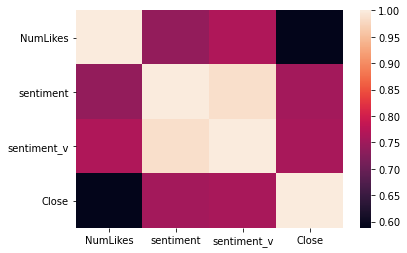

In [47]:
sns.heatmap(merge.corr())

In [93]:
merge['sentiment'].corr(merge['Close'])

0.7759133176222264

Index of the max corr 6
Max corr 0.7606522897072838


C:\Users\whiwho\Anaconda3\envs\JABA\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

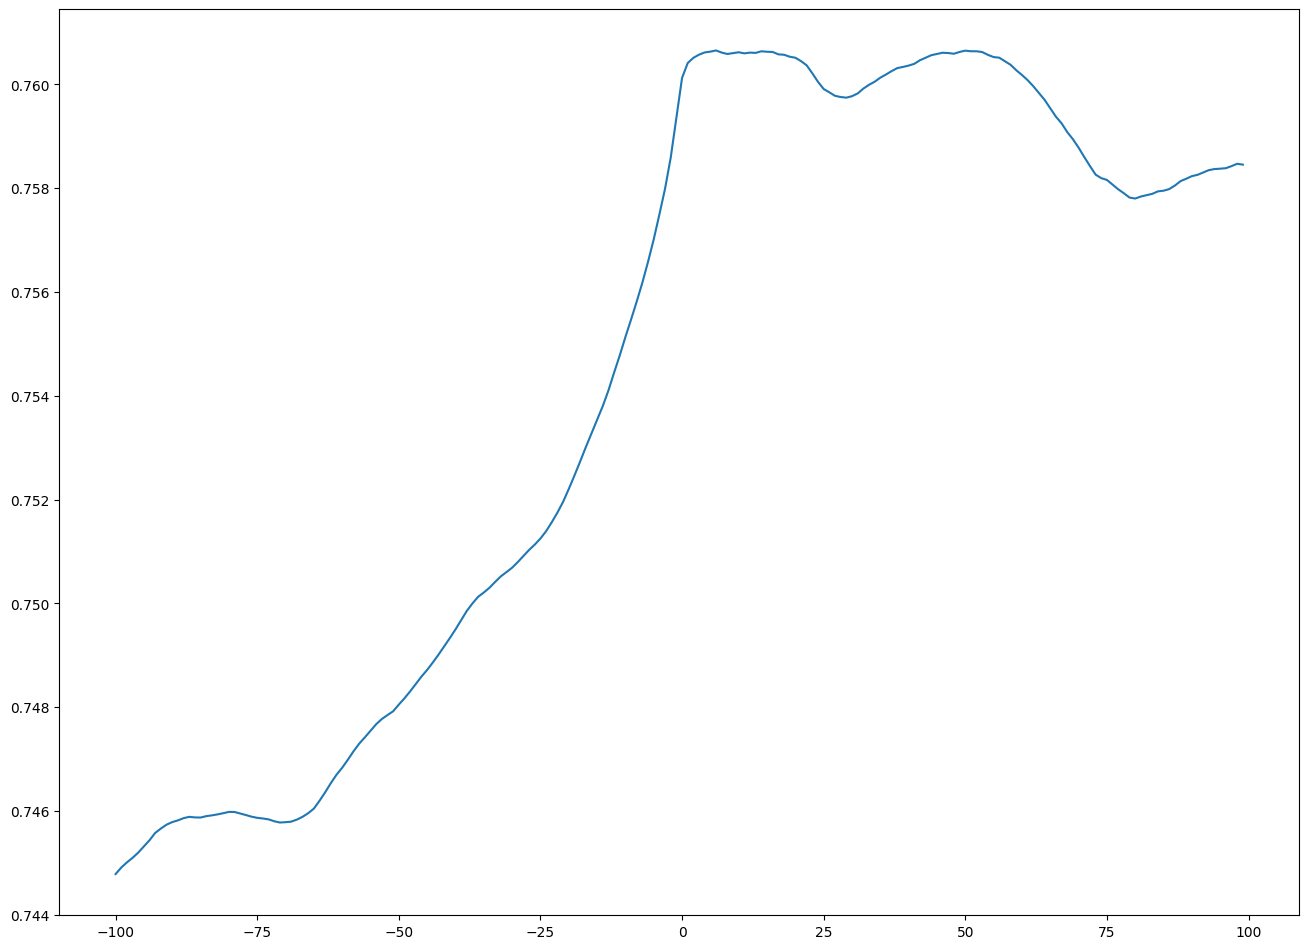

In [25]:
coor_data = []

corr_index_range = 100

for i in range(-corr_index_range,corr_index_range):
    merge2 = merge.shift(periods=i)
    #print(f"Con shift %i el corr es %.4f " % (i, merge2['sentiment_zz'].corr(merge['Close'])))
    coor_data += [merge2['sentiment_zz'].corr(merge['Close'])]


print(f"Index of the max corr {-corr_index_range+coor_data.index(max(coor_data))}")
print(f"Max corr {max(coor_data)}")

sns.lineplot(range(-100,100),coor_data)

In [97]:
merge['NumLikes_y2'] = merge['NumLikes'] * 4.5

In [78]:
merge['sentiment_zz'] = merge['sentiment_v'] * 52

In [79]:
import matplotlib.pyplot as plt

In [58]:
merge['sentiment_zz'] = np.log(merge['sentiment_zz'])
merge['Close'] = np.log(merge['Close'])

C:\Users\whiwho\Anaconda3\envs\JABA\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'Price (USD)')

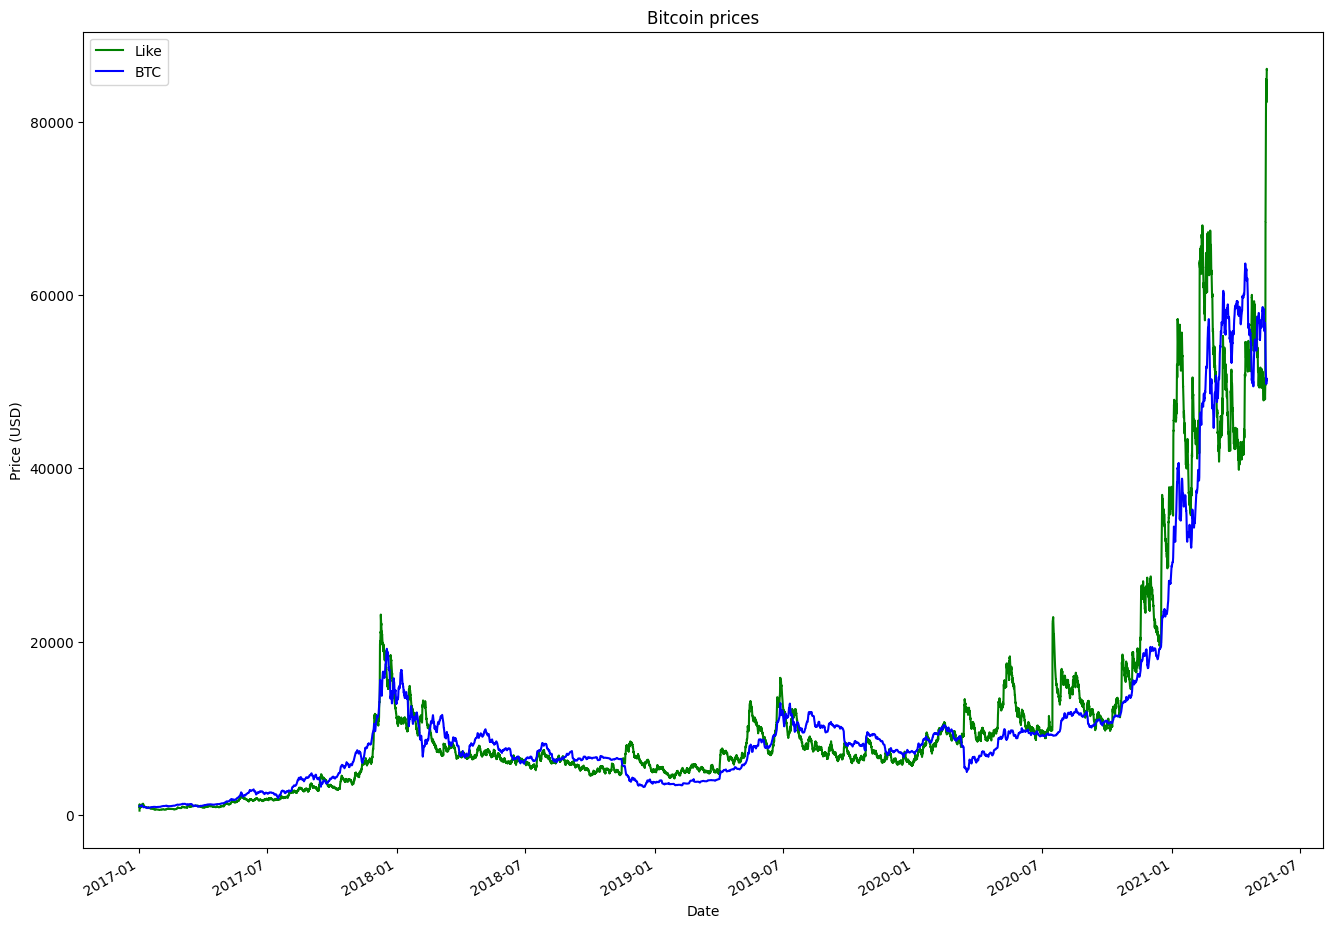

In [98]:
#merge['sentiment_zz'].ewm(span = 600).mean().plot(style = 'g', label = 'Sentiment V2')
#merge['sentiment_v'].ewm(span = 500).mean().plot(style = 'b', label = 'Sentiment')
merge['NumLikes_y2'].ewm(span = 500).mean().plot(style = 'g', label = 'Like')
merge['Close'].ewm(span = 40).mean().plot(style = 'b', label = 'BTC')

plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['figure.dpi'] = 100
plt.legend()
plt.title("Bitcoin prices")
plt.xlabel('Date')
plt.ylabel('Price (USD)')

In [ ]:
merge['sentiment_zz'].ewm(span = 300).mean().plot(style = 'b', label = 'Sentiment')
merge['close'].ewm(span = 30).mean().plot(style = 'r', label = 'BTC')

plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['figure.dpi'] = 100
plt.legend()
plt.title("Bitcoin prices")
plt.xlabel('Date')
plt.ylabel('Price (USD)')

## **ARIMA**

In [61]:
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA

model=ARIMA(merge['Close'],order=(1, 1,1 ))


results=model.fit()


NameError: name 'AutoReg' is not defined

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

model=AutoReg(merge['Close'], lags=12000)


results=model.fit()



In [ ]:
from pandas.tseries.offsets import DateOffset

#future_df['close'] = future_df['close'].fillna(0)
result_data = results.predict(start = 71881, end = 82001, dynamic= False)
pd.concat([merge['Close'], result_data[236:]]).plot(figsize=(12, 8))

In [53]:
len(merge['Close'])

71881

## Linear regression

No vale de nada, pero es para probar un poco.

In [22]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [26]:
reg = LinearRegression().fit(merge[['Close']].to_numpy(), merge['sentiment_v'].to_numpy())

In [29]:
reg.score(merge[['Close']].to_numpy(), merge['sentiment_v'].to_numpy())

0.5590699448269882